# Compare Solutions: Full Seeds vs Excluded Seeds

This notebook compares the full result with all seeds against the same result with specific seeds excluded.
Both solutions include the tree removal optimization trick.

In [1]:
%matplotlib widget
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import pack_vis
import pack_dimer
import pack_vis_sol
import pack_cost
import pack_io
import numpy as np
import cupy as cp
import copy
import pandas as pd
import matplotlib.pyplot as plt
import mplcursors
import glob
from tqdm import tqdm
kgs.set_float32(True)

MAX_N_TREES = 200
# Maximum number of trees to process

local


In [2]:
# Configure which seeds to exclude
excluded_seeds = [120,121,122,123,124,125,126,127,128,129]  # Example: [42, 123, 456] - modify as needed
#excluded_seeds = [87]  # Example: [42, 123, 456] - modify as needed

In [3]:
# Load all data sources once (this takes time)
print("Loading CSV sources...")
theirs = pack_io.dataframe_to_solution_list(pd.read_csv(kgs.code_dir + '../res/70.74.csv'))
my_old_csv_result = pack_io.dataframe_to_solution_list(pd.read_csv(kgs.code_dir + '../res/my_old_with_85.csv'))
# Extract solutions list from tuple (solutions, scores)
my_old_csv = my_old_csv_result[0] if isinstance(my_old_csv_result, tuple) else my_old_csv_result

print("Loading pickle sources...")
pickle_sources = [kgs.code_dir + '../res/tess_legalized.pickle'] + glob.glob(kgs.code_dir + '../res/ga_*.pickle')
pickle_solutions = [kgs.dill_load(x) for x in pickle_sources]

print("Loading controller runs...")
# Load all controller runs and store with metadata
controller_runs = {}  # N_trees -> [(filepath, solution, score, seed)]
for N_trees in tqdm(np.arange(1, MAX_N_TREES + 1)):
    paths = (glob.glob(kgs.temp_dir + f'/*runs/done/ga_N{N_trees}_*.pickle') + 
             glob.glob(kgs.temp_dir + f'/*runs/extra/ga_N{N_trees}_*.pickle') + 
             glob.glob(kgs.temp_dir + f'/*runs/repro/ga_N{N_trees}_*.pickle') + 
             glob.glob(kgs.temp_dir + f'/rerun_done/done/ga_N{N_trees}_*.pickle'))
    
    if len(paths) > 0:
        controller_runs[N_trees] = []
        for path in paths:
            #print(f"Loading {path}")
            result = kgs.dill_load(path)
            solution = result.ga.champions[0].phenotype
            # Compute score from solution.h directly (not from fitness metadata)
            # to be consistent with later dtype conversions
            score = (solution.h[0, 0]**2).get() / solution.N_trees
            
            # Extract seed from filename (format: ga_N{N}_seed{seed}_...)
            seed = None
            basename = os.path.basename(path)
            if '_seed' in basename:
                try:
                    seed_part = basename.split('_seed')[1].split('_')[0]
                    seed = int(seed_part)
                except:
                    pass
            
            controller_runs[N_trees].append((path, solution, score, seed))

print(f"Loaded data for {len(controller_runs)} different N_trees values")

Loading CSV sources...
Loading pickle sources...
Loading controller runs...


100%|██████████| 200/200 [03:44<00:00,  1.12s/it]

Loaded data for 150 different N_trees values


In [4]:
def aggregate_best_solutions(include_controller_filter=None):
    """
    Aggregate best solutions from all sources.
    
    Args:
        include_controller_filter: Function that takes (N_trees, path, seed) and returns bool
                                   If None, includes all controller runs
    """
    # Combine all solution sources
    all_sources = []
    
    # Add CSV sources
    # theirs is a tuple (solutions, scores) or just solutions
    if isinstance(theirs, tuple):
        all_sources.append(theirs[0])
    else:
        all_sources.append(theirs)
    
    # my_old_csv is already a list of solutions, add it directly
    all_sources.append(my_old_csv)
    
    # Add pickle solutions - each pickle contains a list of solutions
    for ps in pickle_solutions:
        if isinstance(ps, tuple):
            # If it's a tuple like (solutions, scores), take solutions
            all_sources.append(ps[0])
        else:
            # Otherwise it's already a list of solutions
            all_sources.append(ps)
    
    # Add controller runs (filtered)
    controller_solutions = []
    for N_trees in np.arange(1, MAX_N_TREES + 1):
        if N_trees in controller_runs:
            best_sol = None
            best_score = np.inf
            
            for path, solution, score, seed in controller_runs[N_trees]:
                # Apply filter if provided
                if include_controller_filter is not None:
                    if not include_controller_filter(N_trees, path, seed):
                        continue
                
                if score < best_score:
                    best_score = score
                    best_sol = solution
            
            if best_sol is not None:
                controller_solutions.append(best_sol)
    
    if controller_solutions:
        all_sources.append(controller_solutions)
    
    # Convert to correct dtype - create new lists with deep copies to avoid mutating original source lists
    all_sources_copied = []
    for source in all_sources:
        source_copy = []
        for sol in source:
            # Deep copy the solution to avoid modifying shared objects between calls
            sol_copy = copy.deepcopy(sol)
            sol_copy.xyt = sol_copy.xyt.astype(kgs.dtype_cp)
            sol_copy.h = sol_copy.h.astype(kgs.dtype_cp)
            source_copy.append(sol_copy)
        all_sources_copied.append(source_copy)
    
    # Use the copied sources
    all_sources = all_sources_copied
    
    # Find best solution for each N_trees
    best_solutions = []
    best_scores = []
    
    for N_trees in np.arange(1, MAX_N_TREES + 1):
        best_score = np.inf
        best_sol = None
        
        for source in all_sources:
            for sol in source:
                if sol.N_trees == N_trees:
                    score = (sol.h[0, 0]**2).get() / sol.N_trees
                    if score < best_score:
                        best_score = score
                        best_sol = sol
        
        if best_sol is not None:
            best_solutions.append(best_sol)
            best_scores.append(best_score)
        else:
            # This shouldn't happen, but handle gracefully
            raise ValueError(f"No solution found for N_trees={N_trees}")
    
    return best_solutions, best_scores

In [5]:
# Create base solution (all seeds)
print("Aggregating base solution (all seeds)...")
base_solutions, base_scores = aggregate_best_solutions(include_controller_filter=None)

# Create comparison solution (excluding specified seeds)
print(f"Aggregating comparison solution (excluding seeds: {excluded_seeds})...")
def exclude_seeds_filter(N_trees, path, seed):
    if seed is None:
        return True  # Include if we can't determine seed
    return seed not in excluded_seeds

comparison_solutions, comparison_scores = aggregate_best_solutions(
    include_controller_filter=exclude_seeds_filter if excluded_seeds else None
)

print(f"Base total score: {np.sum(base_scores):.6f}")
print(f"Comparison total score: {np.sum(comparison_scores):.6f}")
print(f"Difference: {np.sum(comparison_scores) - np.sum(base_scores):.6f}")

Aggregating base solution (all seeds)...
Aggregating comparison solution (excluding seeds: [120, 121, 122, 123, 124, 125, 126, 127, 128, 129])...
Base total score: 69.258369
Comparison total score: 69.266144
Difference: 0.007774


In [6]:
def apply_tree_removal_trick(solutions, scores):
    """
    Apply tree removal optimization trick.
    Works backwards from N=MAX_N_TREES to N=1, trying to remove trees from N+1 solution.
    """
    N_trees = np.arange(1, MAX_N_TREES + 1)
    optimized_solutions = [None] * MAX_N_TREES
    optimized_scores = [None] * MAX_N_TREES
    
    # Work backwards to allow solutions to propagate
    for i in range(MAX_N_TREES-1, -1, -1):
        n = N_trees[i]
        
        # Start with current best solution
        best_sol = copy.deepcopy(solutions[i])
        best_score = scores[i]
        
        # Try removing a tree from N+1 solution if available
        if i + 1 < len(N_trees) and optimized_solutions[i+1] is not None:
            next_sol = optimized_solutions[i+1]
            
            # Try removing each tree from N+1
            for tree_idx in range(next_sol.N_trees):
                test_sol = copy.deepcopy(next_sol)
                
                # Remove the tree by slicing
                test_sol.xyt = cp.concatenate([
                    test_sol.xyt[:, :tree_idx, :],
                    test_sol.xyt[:, tree_idx+1:, :]
                ], axis=1)
                
                # Calculate new score
                test_score = (test_sol.h[0, 0]**2).get() / test_sol.N_trees
                
                # If better, use it
                if test_score < best_score:
                    best_sol = test_sol
                    best_score = test_score
        
        optimized_solutions[i] = best_sol
        optimized_scores[i] = best_score
    
    return optimized_solutions, optimized_scores

In [7]:
# Apply tree removal trick to both solutions
print("Applying tree removal trick to base solution...")
base_solutions_opt, base_scores_opt = apply_tree_removal_trick(base_solutions, base_scores)

print("Applying tree removal trick to comparison solution...")
comparison_solutions_opt, comparison_scores_opt = apply_tree_removal_trick(
    comparison_solutions, comparison_scores
)

# Calculate improvements
base_improvement = np.sum(base_scores) - np.sum(base_scores_opt)
comparison_improvement = np.sum(comparison_scores) - np.sum(comparison_scores_opt)

print("\n=== Results Summary ===")
print(f"Base (all seeds):")
print(f"  Before trick: {np.sum(base_scores):.6f}")
print(f"  After trick:  {np.sum(base_scores_opt):.6f}")
print(f"  Improvement:  {base_improvement:.6f}")
print(f"\nComparison (excluded seeds: {excluded_seeds}):")
print(f"  Before trick: {np.sum(comparison_scores):.6f}")
print(f"  After trick:  {np.sum(comparison_scores_opt):.6f}")
print(f"  Improvement:  {comparison_improvement:.6f}")
print(f"\nFinal difference (comparison - base): {np.sum(comparison_scores_opt) - np.sum(base_scores_opt):.6f}")

Applying tree removal trick to base solution...
Applying tree removal trick to comparison solution...

=== Results Summary ===
Base (all seeds):
  Before trick: 69.258369
  After trick:  68.945572
  Improvement:  0.312798

Comparison (excluded seeds: [120, 121, 122, 123, 124, 125, 126, 127, 128, 129]):
  Before trick: 69.266144
  After trick:  68.959335
  Improvement:  0.306808

Final difference (comparison - base): 0.013763


In [8]:
# Create detailed comparison table
N_trees = np.arange(1, MAX_N_TREES + 1)
comparison_df = pd.DataFrame({
    'N_trees': N_trees,
    'base_before': base_scores,
    'base_after': base_scores_opt,
    'comparison_before': comparison_scores,
    'comparison_after': comparison_scores_opt,
    'base_improvement': np.array(base_scores) - np.array(base_scores_opt),
    'comparison_improvement': np.array(comparison_scores) - np.array(comparison_scores_opt),
    'delta_before': np.array(comparison_scores) - np.array(base_scores),
    'delta_after': np.array(comparison_scores_opt) - np.array(base_scores_opt),
})

# Show only rows where there's a difference
changed_rows = comparison_df[comparison_df['delta_after'].abs() > 1e-9]
print(f"\n{len(changed_rows)} N_trees values changed after seed exclusion:")
print(changed_rows.to_string(index=False))


17 N_trees values changed after seed exclusion:
 N_trees  base_before  base_after  comparison_before  comparison_after  base_improvement  comparison_improvement  delta_before  delta_after
      86     0.338962    0.338962           0.339698          0.339698          0.000000                0.000000      0.000736     0.000736
      94     0.338191    0.338191           0.338636          0.338636          0.000000                0.000000      0.000444     0.000444
     109     0.340558    0.340222           0.340558          0.340225          0.000336                0.000332      0.000000     0.000004
     110     0.337129    0.337129           0.337132          0.337132          0.000000                0.000000      0.000004     0.000004
     123     0.349486    0.336738           0.349486          0.337607          0.012748                0.011879      0.000000     0.000869
     124     0.334022    0.334022           0.334884          0.334884          0.000000                0.00000

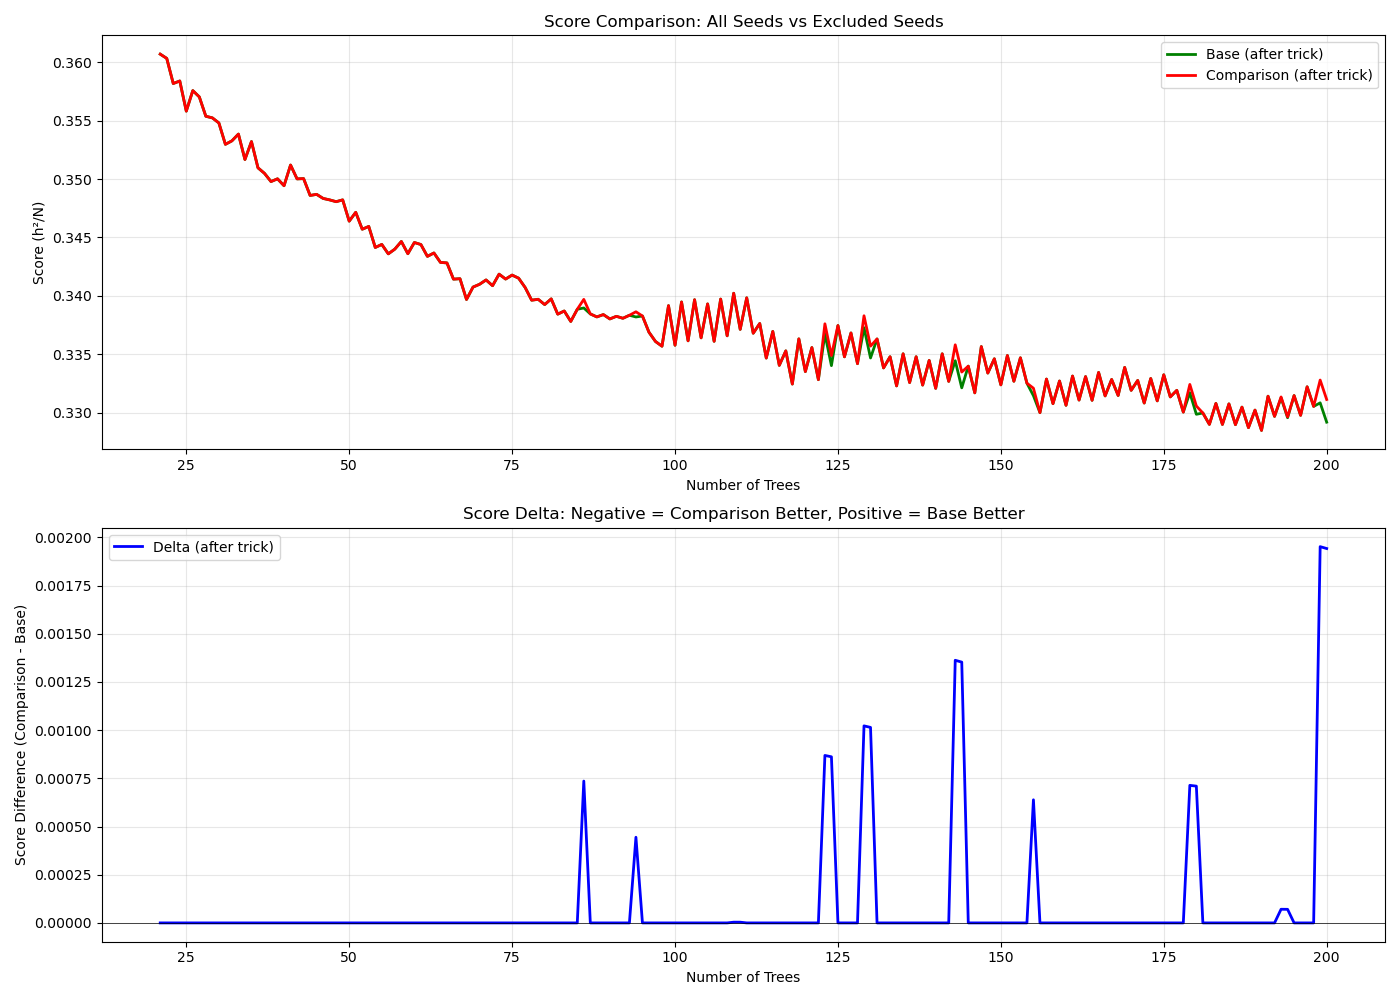

In [9]:
# Visualization: Score comparison
N_start = 20  # Start plotting from N=20 for clarity

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Before and after optimization
ax = axes[0]
lines = []
#lines.extend(ax.plot(N_trees[N_start:], base_scores[N_start:], 'g--', 
#                     label='Base (before trick)', linewidth=1.5, alpha=0.7))
lines.extend(ax.plot(N_trees[N_start:], base_scores_opt[N_start:], 'g-', 
                     label='Base (after trick)', linewidth=2))
#lines.extend(ax.plot(N_trees[N_start:], comparison_scores[N_start:], 'r--', 
#                     label='Comparison (before trick)', linewidth=1.5, alpha=0.7))
lines.extend(ax.plot(N_trees[N_start:], comparison_scores_opt[N_start:], 'r-', 
                     label='Comparison (after trick)', linewidth=2))
ax.grid(True, alpha=0.3)
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Score (h²/N)')
ax.set_title('Score Comparison: All Seeds vs Excluded Seeds')
ax.legend(fontsize=10)
mplcursors.cursor(lines, hover=True)

# Plot 2: Delta (comparison - base)
ax = axes[1]
delta_before = np.array(comparison_scores) - np.array(base_scores)
delta_after = np.array(comparison_scores_opt) - np.array(base_scores_opt)

lines = []
#lines.extend(ax.plot(N_trees[N_start:], delta_before[N_start:], 'b--', 
#                     label='Delta (before trick)', linewidth=1.5, alpha=0.7))
lines.extend(ax.plot(N_trees[N_start:], delta_after[N_start:], 'b-', 
                     label='Delta (after trick)', linewidth=2))
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3)
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Score Difference (Comparison - Base)')
ax.set_title('Score Delta: Negative = Comparison Better, Positive = Base Better')
ax.legend(fontsize=10)
mplcursors.cursor(lines, hover=True)

plt.tight_layout()

In [10]:
# Analyze seed impact (which excluded seeds were important?)
if excluded_seeds:
    seed_impact = {seed: {'count': 0, 'score_loss': 0.0} for seed in excluded_seeds}
    
    for N_trees in np.arange(1, MAX_N_TREES + 1):
        if N_trees not in controller_runs:
            continue
        
        # Find which seed was best for this N_trees
        best_seed = None
        best_score = np.inf
        
        for path, solution, score, seed in controller_runs[N_trees]:
            if seed in excluded_seeds and score < best_score:
                best_score = score
                best_seed = seed
        
        # Check if this excluded seed was actually the best
        if best_seed is not None:
            idx = N_trees - 1
            score_loss = comparison_scores_opt[idx] - base_scores_opt[idx]
            if score_loss > 1e-9:  # Comparison is worse
                seed_impact[best_seed]['count'] += 1
                seed_impact[best_seed]['score_loss'] += score_loss
    
    print("\n=== Seed Impact Analysis ===")
    print("Seeds that were best for some N_trees:")
    for seed, impact in sorted(seed_impact.items(), key=lambda x: x[1]['score_loss'], reverse=True):
        if impact['count'] > 0:
            print(f"  Seed {seed}: Best for {impact['count']} N_trees, total score loss: {impact['score_loss']:.6f}")


=== Seed Impact Analysis ===
Seeds that were best for some N_trees:
  Seed 120: Best for 3 N_trees, total score loss: 0.003317
  Seed 121: Best for 4 N_trees, total score loss: 0.002577
  Seed 122: Best for 2 N_trees, total score loss: 0.001876
  Seed 123: Best for 1 N_trees, total score loss: 0.000004


In [11]:
# Optional: Save optimized solutions to CSV
# Uncomment to save:
# print("Saving base solution...")
# pdx = pack_io.solution_list_to_dataframe(base_solutions_opt, compact=False)
# pdx.to_csv(kgs.temp_dir + 'submission_base.csv', index=False)
# 
# print("Saving comparison solution...")
# pdx = pack_io.solution_list_to_dataframe(comparison_solutions_opt, compact=False)
# pdx.to_csv(kgs.temp_dir + 'submission_comparison.csv', index=False)